## Data Description
Suatu waralaba supermarket bernama Good Seed ingin mengetahui apakah Data Science dapat membantu mereka mematuhi hukum dengan memastikan bahwa mereka tidak menjual produk yang memiliki batasan usia kepada pelanggan di bawah umur. Anda pun diminta untuk melaksanakan evaluasi. Oleh karena itu, saat Anda mulai bekerja, ingatlah hal-hal berikut ini:

- Toko-toko dari waralaba ini dilengkapi dengan kamera di area kasir yang akan menampilkan sinyal ketika seseorang membeli produk dengan batasan usia
- Metode visi komputer bisa digunakan untuk menentukan usia seseorang dari foto
- Tugas Anda adalah membangun dan mengevaluasi sebuah model untuk memverifikasi usia seseorang

Untuk mulai mengerjakan tugas ini, Anda akan mendapatkan satu set foto orang dengan keterangan usianya.

**Goal Project:** Membangun dan mengevaluasi sebuah model untuk memverifikasi usia seseorang. 

## Inisialisasi 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

## Memuat Data

*Dataset* yang Anda perlukan disimpan di folder `/datasets/faces/`. Pada folder tersebut, Anda bisa menemukan: - Folder `final_file` dengan 7,6 ribu foto 
- *File* `labels.csv` yang memuat label, dengan dua kolom: `file_name` dan `real_age` 

Mengingat jumlah *file* gambar cukup banyak, Anda disarankan untuk tidak membacanya sekaligus, karena hal ini hanya akan menghabiskan sumber daya komputasi. Kami sarankan Anda untuk membuat generator dengan ImageDataGenerator. Metode ini telah dijelaskan sebelumnya di Bab 3, Pelajaran ke-7. 

*File* label bisa dimuat sebagai *file* CSV biasa.

In [2]:
path = '/datasets/faces/'
file_labels = path + 'labels.csv'
file_faces = path + 'final_files/'

df = pd.read_csv(file_labels)

In [3]:
# membuat fungsi pengolahan data

def display_information(df):
    print('Head:')
    display(df.head())
    print ('-'*100)
    print('Tail:')
    display(df.tail())
    print ('-'*100)
    print('Info:')
    display(df.info())
    print ('-'*100)
    print('Describe:')
    display(df.describe())
    print ('-'*100)
    print('Skew Factor:')
    display(df.skew())
    print ('-'*100)
    print('Columns with nulls:')
    display(get_precent_of_na_df(df,4))
    print ('-'*100)
    print('Shape:')
    print(df.shape)
    print ('-'*100)
    print('Duplicated:')
    print('Duplicate rows:',df.duplicated().sum(),', Duplicate percentage:', (df.duplicated().sum()*100) / df.shape[0],'%')
    
def get_precent_of_na_df(df,num):
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    df_nulls['Percent of Nulls'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    return df_nulls

print_separator = '*' * 100

In [4]:
display_information(df)
print ('-'*100)

Head:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


----------------------------------------------------------------------------------------------------
Tail:


,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

----------------------------------------------------------------------------------------------------
Describe:


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


----------------------------------------------------------------------------------------------------
Skew Factor:


real_age    0.729609
dtype: float64

----------------------------------------------------------------------------------------------------
Columns with nulls:


,Missing Values,Percent of Nulls
file_name,0,0.0
real_age,0,0.0


----------------------------------------------------------------------------------------------------
Shape:
(7591, 2)
----------------------------------------------------------------------------------------------------
Duplicated:
Duplicate rows: 0 , Duplicate percentage: 0.0 %
----------------------------------------------------------------------------------------------------


- Terdapat 7591 wajah dalam dataset.
- Tidak ada missing value atau nilai yang terduplikasi.
- Usia rata-rata seseorang adalah 31 tahun, dan rentang usia dari 1 tahun hingga 100 tahun.

## 1. EDA (Exploratory data analysis)

Lakukan analisis data eksploratif:
- Amati ukuran dataset.
- Jelajahi distribusi usia pada dataset.
- Menampilkan 10-15 foto untuk usia yang berbeda pada layar agar bisa memahami gambaran umum dataset.
- File path untuk analisis:
    - `'/datasets/faces/labels.csv'`
    - `'/datasets/faces/final_files/'`
- Sajikan hasil temuan tentang bagaimana spesifikasi dataset dapat memengaruhi cara model dilatih.

<AxesSubplot:xlabel='real_age', ylabel='Density'>

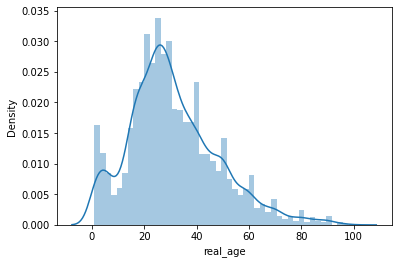

In [5]:
sns.distplot(df['real_age'])

- Kebanyakan orang berada di rentang usia 30-an. Maks 317 gambar untuk usia 30 tahun.
- Sangat sedikit orang dalam kisaran di atas 80.
- Kisaran orang yang baik dalam rentang usia 0-5.

In [6]:
bins = [0,10,20,30,40,50,60,70,80,90,100]
df['agerange'] = pd.cut(df['real_age'], bins)
display(df.head(5))

,file_name,real_age,agerange
0,000000.jpg,4,"(0, 10]"
1,000001.jpg,18,"(10, 20]"
2,000002.jpg,80,"(70, 80]"
3,000003.jpg,50,"(40, 50]"
4,000004.jpg,17,"(10, 20]"


In [7]:
df_stats = df.pivot_table(index=['agerange'],values='real_age',aggfunc=['count'])
df_stats.columns = [('Count')]
df_stats

,Count
agerange,
"(0, 10]",708
"(10, 20]",1346
"(20, 30]",2214
"(30, 40]",1414
"(40, 50]",929
"(50, 60]",534
"(60, 70]",254
"(70, 80]",111
"(80, 90]",68


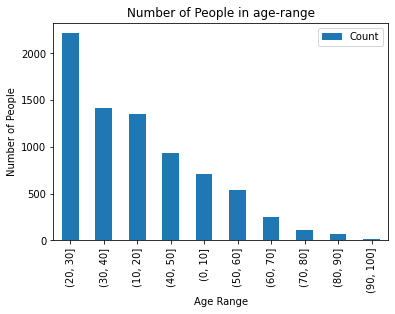

In [8]:
df_stats.sort_values(by='Count', ascending=False).plot(kind='bar',title='Number of People in age-range')
plt.xlabel('Age Range')
plt.ylabel('Number of People')
plt.show();

- Kebanyakan orang berada dalam rentang usia 20-30.
- Hanya sedikit orang yang berusia 60 tahun ke atas.
- Ini akan menghasilkan deteksi yang baik terhadap orang-orang dalam rentang usia di bawah 60 tahun.

<AxesSubplot:xlabel='real_age'>

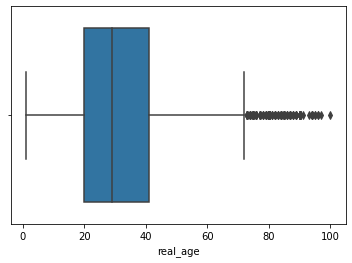

In [9]:
sns.boxplot(df['real_age'])

- Boxplot mengkonfirmasi bahwa orang yang berusia sekitar 70 tahun merupakan outliers, menandakan sangat sedikit gambar orang di atas usia 70 tahun.

In [10]:
print(df['file_name'].head(5))
arr = file_faces + df['file_name']
age = df['real_age']

0    000000.jpg
1    000001.jpg
2    000002.jpg
3    000003.jpg
4    000004.jpg
Name: file_name, dtype: object


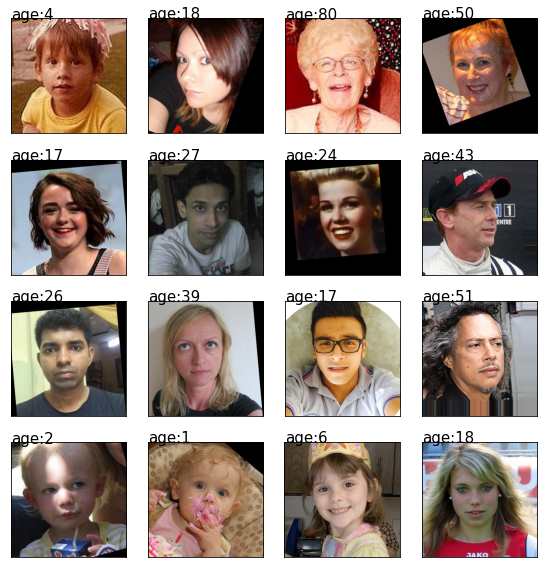

In [11]:
fig = plt.figure(figsize=(8,8))
for i in range(16):
    image = Image.open(arr[i])
    array = np.array(image)
    array = array/255
    
    ax = fig.add_subplot(4, 4, i+1)
    ax.annotate('age:' + str(age[i]), fontsize=15, xy=(0.4,0.4))
    plt.imshow(array, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Temuan
- Gambar tampaknya sudah sesuai dengan usia.
- Kebanyakan orang berada pada rentang usia 30-an tahun, sekitar 317 gambar untuk usia 30 tahun.
- Orang dengan usia 80 tahun ke atas jumlahnya sangat sedikit.
- Karena tidak banyak gambar untuk orang dengan usia 60 tahun, training set tidak akan memiliki jumlah data yang baik di atas usia 60 tahun.
- Prediksi usia untuk usia di atas 60 tahun bisa saja salah.
- Gambar tampak cerah, gambar dibalik ke kanan atau ke kiri, namun tidak ada pembalikan vertikal yang terlihat.
- Beberapa gambar diperbesar, beberapa gambar tampak lebih gelap.

## 2. Model Training

Definisikan fungsi-fungsi yang diperlukan untuk melatih model Anda pada platform GPU dan buat satu skrip yang berisi semua fungsi tersebut beserta bagian inisialisasi.

Untuk mempermudah tugas ini, Anda dapat mendefinisikannya dalam *notebook* ini dan menjalankan kode siap pakai di bagian berikutnya untuk menyusun skrip secara otomatis.
Definisi di bawah ini juga akan diperiksa oleh *project reviewer* agar mereka dapat memahami cara Anda membangun model.

In [12]:
def load_train(path):
    
    """
    Kode ini memuat bagian training set dari file path
    """
    
    datagen = ImageDataGenerator(
        horizontal_flip = True,
        validation_split = 0.25,
        rescale = 1.0/255.)

    train_datagen_flow = datagen.flow_from_dataframe(
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'training',
        x_col = 'file_name',
        y_col = 'real_age',
        dataframe = pd.read_csv(path + 'labels.csv'),
        directory = path + 'final_files/',
        seed = 12345)

    return train_datagen_flow

In [13]:
def load_test(path):
    
    """
    Kode ini memuat bagian validation set/test set dari file path
    """
    
    datagen = ImageDataGenerator(
        validation_split = 0.25,
        rescale = 1.0/255.)
    
    test_datagen_flow = datagen.flow_from_dataframe(
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'validation',
        x_col = 'file_name',
        y_col = 'real_age',
        dataframe = pd.read_csv(path + 'labels.csv'),
        directory = path + 'final_files/',
        seed = 12345)

    return test_datagen_flow


In [14]:
def create_model(input_shape):
    
    """
    Kode ini mendefinisikan model
    """
    
    backbone = ResNet50(input_shape=(150,150,3),
                        weights = 'imagenet',
                        include_top = False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation = 'relu'))
    model.add(Dense(1, activation = 'relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model


In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    """
    Melatih model dengan parameter yang diberikan
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data = test_data,
              batch_size = batch_size, epochs = epochs,
              validation_steps = validation_steps,
              verbose = 2, shuffle = True)

    return model

## 3. Siapkan Skrip untuk menjalankan platform GPU

Setelah Anda mendefinisikan fungsi-fungsi yang diperlukan, Anda dapat membuat skrip untuk platform GPU, mengunduhnya melalui menu "File|Open...", dan mengunggahnya nanti untuk dijalankan pada platform GPU. "

Catatan: Skrip Anda juga harus menyertakan bagian inisialisasi. Contohnya ditunjukkan di bawah ini.

In [16]:
# siapkan skrip untuk menjalankan platform GPU


init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Letakkan *output* dari platform GPU sebagai sel *Markdown* di sini.

## Kesimpulan
- Melakukan proses training model sebanyak 5 epochs. 
- Tes akhir MAE adalah 6,1101 pada epoch #5 sekaligus menjadi nilai MAE yang terbaik
- Hasil MAE menunjukkan bahwa usia dibelokkan plus/minus 6,1 untuk setiap gambar. Ini maksudnya, beberapa gambar memiliki usia yang dibelokkan lebih dari yang lain.
- Gambar diaugmentasi untuk horizontal flipping.
- Hasil EDA sesuai dengan apa yang diharapkan. Alasannya: Meskipun ada jumlah gambar yang bagus untuk training set, jumlah usia di kelompok yang lebih tinggi, usia 60 tahun ke atas sangat sedikit (1 untuk setiap usia).
- Jika model training memiliki lebih banyak gambar untuk kelompok usia yang lebih tinggi, maka mendapatkan hasil yang lebih baik.

Perbaikan yang bisa dilakukan:
- Menambahkan augmentasi untuk memperbesar, memperkecil, mempercerah gambar, menggeser sedikit ke kanan atau kiri.

In [17]:
print("Thank you for evaluating my project, Looking forward to your feedback")

Thank you for evaluating my project, Looking forward to your feedback


# Daftar Periksa

- [ ]  *Notebook* dibuka 
- [ ]  Tidak ada kesalahan dalam kode 
- [ ]  Sel dengan kode telah disusun berdasarkan urutan eksekusi 
- [ ]  Analisis data eksploratif telah dijalankan - [ ]  Hasil dari analisis data eksploratif ditampilkan pada *notebook* final - [ ]  Skor MAE model tidak lebih tinggi dari 8 
- [ ]  Kode pelatihan model telah disalin ke *notebook* final 
- [ ]  *Output* pelatihan model telah disalin di *notebook* final 
- [ ]  Temuan telah diberikan berdasarkan hasil pelatihan model 